In [28]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt

In [29]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [30]:
#load data
company = 'FB'

In [31]:
start = dt.datetime(2012,1,1)
end = dt.datetime(2020,1,1)

In [32]:
data = web.DataReader(company, 'yahoo', start, end)

In [43]:
data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-05-18,45.000000,38.000000,42.049999,38.230000,573576400,38.230000
2012-05-21,36.660000,33.000000,36.529999,34.029999,168192700,34.029999
2012-05-22,33.590000,30.940001,32.610001,31.000000,101786600,31.000000
2012-05-23,32.500000,31.360001,31.370001,32.000000,73600000,32.000000
2012-05-24,33.209999,31.770000,32.950001,33.029999,50237200,33.029999
...,...,...,...,...,...,...
2019-12-24,206.789993,205.000000,206.300003,205.119995,6046300,205.119995
2019-12-26,207.820007,205.309998,205.570007,207.789993,9350700,207.789993
2019-12-27,208.929993,206.589996,208.669998,208.100006,10284200,208.100006


In [46]:
#Prepare Data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))
prediction_days = 60

In [49]:
x_train = []
y_train = []

In [50]:
for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x , 0])
    y_train.append(scaled_data[x,0])

In [51]:
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))

In [52]:
#Build the Model
model = Sequential()

model.add(LSTM(units=50,return_sequences = True,input_shape =( x_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units= 1)) #Prediction of the next closing price

model.compile(optimizer = 'adam' , loss='mean_squared_error')

In [53]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 60, 50)            10400     
                                                                 
 dropout_6 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_7 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_7 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_8 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_8 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                

In [37]:

model.fit(x_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
59/59 [==============================] - 8s 50ms/step - loss: 0.0199
Epoch 2/25
59/59 [==============================] - 3s 55ms/step - loss: 0.0041
Epoch 3/25
59/59 [==============================] - 3s 58ms/step - loss: 0.0035
Epoch 4/25
59/59 [==============================] - 3s 50ms/step - loss: 0.0038
Epoch 5/25
59/59 [==============================] - 3s 50ms/step - loss: 0.0037
Epoch 6/25
59/59 [==============================] - 3s 54ms/step - loss: 0.0028
Epoch 7/25
59/59 [==============================] - 3s 53ms/step - loss: 0.0034: 0s - l
Epoch 8/25
59/59 [==============================] - 4s 65ms/step - loss: 0.0034
Epoch 9/25
59/59 [==============================] - 3s 59ms/step - loss: 0.0028
Epoch 10/25
59/59 [==============================] - 4s 62ms/step - loss: 0.0027
Epoch 11/25
59/59 [==============================] - 3s 58ms/step - loss: 0.0028
Epoch 12/25
59/59 [==============================] - 4s 70ms/step - loss: 0.0028
Epoch 13/25
59/59 [==========

In [38]:
#Test the model accuracy on existing data
#load test data

test_start = dt.datetime(2020,1,1)
test_end = dt.datetime.now()

test_data = web.DataReader(company, 'yahoo', test_start, test_end)
actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']))

In [39]:
model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

In [40]:
#make predictions on test data
x_test = []

for x in range(prediction_days , len(model_inputs)):
    x_test.append(model_inputs[x - prediction_days: x , 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))


In [41]:
predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

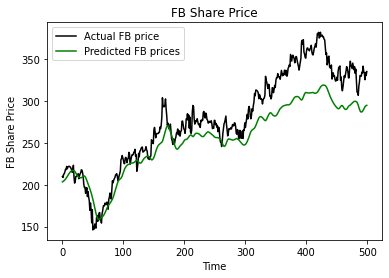

In [42]:
#Plot the test predictions

plt.plot(actual_prices , color = 'black' , label=f"Actual {company} price")
plt.plot(predicted_prices , color = 'green', label = f"Predicted {company} prices")
plt.title(f"{company} Share Price")
plt.xlabel('Time')
plt.ylabel(f'{company} Share Price')
plt.legend()
plt.show()